In [1]:
import os

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

# Implementation and Training of VideoColorizer UNet model

First without optical flow


Inputs:
- previous frame: L, ab channels
- current frame: L channel

Outputs:
- current frame: ab channels

In [2]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
def cartToPol(x, y):  
    # Convert cartesian to polar coordinates (for optical flow)
    
    ang = np.arctan2(y, x)
    mag = np.hypot(x, y)
    return mag, ang

def uv_2_rgb(image_uv, resize=False):
    # Convert the optical flow field into HSV Polar coordinate representation

    uv_shape = image_uv.shape
    hsv = np.zeros((uv_shape[0], uv_shape[1], 3))
    hsv[..., 1] = 255

    # Encoding: convert the algorithm's output into Polar coordinates
    mag, ang = cartToPol(image_uv[..., 0], image_uv[..., 1])
    # Use Hue and Value to encode the Optical Flow
    hsv[..., 0] = (ang+np.pi) * 180 / ( 2 * np.pi )
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    #print(hsv)
    hsv = np.round(hsv).astype(np.uint8)
    #print(hsv)
    # Convert HSV to RGB (BGR) color representation
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

## 1. Data Loading

using the pytorch dataloader and dataset implementation from DataLoad.py

In [4]:
from DataLoad import CustomImageDataset, data_to_images

In [5]:
use_flow=True

dataset = CustomImageDataset(resolution='176p', use_flow=use_flow)

dataset_size = len(dataset)
print('Dataset size:', dataset_size)

vid labels: ['basketball-game', 'bmx-rider', 'butterfly', 'car-competition', 'cat', 'chairlift', 'circus', 'dog-competition', 'dolphins-show', 'drone-flying', 'ducks', 'giraffes', 'gym-ball', 'helicopter-landing', 'horse-race', 'hurdles-race', 'ice-hockey', 'jet-ski', 'juggling-selfie', 'kids-robot', 'mantaray', 'mascot', 'motorbike-race', 'obstacles', 'plane-exhibition', 'robot-battle', 'snowboard-race', 'swimmer', 'tram', 'trucks-race']
Dataset size: 2264


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 4, 320, 176])
Labels batch shape: torch.Size([64, 2, 320, 176])


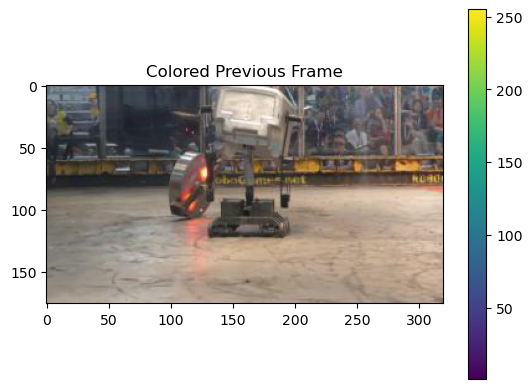

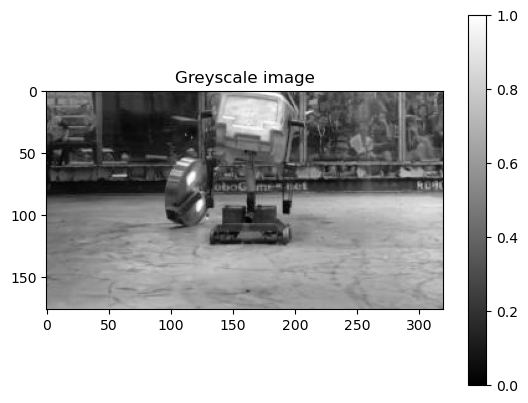

In [7]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

col_img, flow_img, grey_img = data_to_images(train_features[0], train_labels[0], use_flow=use_flow, input_only=True)

im = plt.imshow(col_img)
cbar = plt.colorbar(im)
plt.title('Colored Previous Frame')
plt.show()

im = plt.imshow(grey_img, cmap='gray')
cbar = plt.colorbar(im)
plt.title('Greyscale image')
plt.show()


if use_flow:
    flow_rgb = uv_2_rgb(flow_img)

    im = plt.imshow(flow_rgb)
    cbar = plt.colorbar(im)
    plt.title('Optical flow')
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for ax in enumerate(axs):
        ax[1].axis('off')
        ax[1].set_title('Flow channel ' + str(ax[0]))
        im = ax[1].imshow(flow_img[:, :, ax[0]], cmap='gray')
        cbar = fig.colorbar(im, ax=ax[1])
        
    plt.show()

## 2. Model Definition

In [8]:
from Model_UNet import UNet

print("Cuda available: ", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Cuda available:  True
Using device:  cuda


In [9]:
#initialize model
model = UNet()
model.to(device)

# Hyperparameters
learning_rate = 1e-3
batch_size = 16
epochs = 5

# Initialize the loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Data loader
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
model_path = '~/Documents/Colorization/Models/'
UNet_folder = 'UNet'
model_path = os.path.expanduser(model_path)
UNet_folder = os.path.join(model_path, UNet_folder)

def checkpoint(model, filename):
    filename = os.path.join(UNet_folder, filename)
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    filename = os.path.join(UNet_folder, filename)
    model.load_state_dict(torch.load(filename))

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if verbose:
            print('batch No:', batch)
            print('X shape:', X.shape)
            print('y shape:', y.shape)
        
        # Compute prediction and loss
        if torch.cuda.is_available():
            X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss, current = loss.item(), (batch + 1) * len(X)
    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
epochs = 50
checkpoint_path = 'UNet_Flow'
checkpoint_path = os.path.join(checkpoint_path, UNet_folder)
make_dir(checkpoint_path)

save_model = True

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    if t % 5 == 0 and save_model:
        checkpoint(model, 'UNet_noFlow_epoch_' + str(t) + '.pth')
print("Done!")

Epoch 1
-------------------------------
loss: 0.014001  [ 1136/ 2264]
Epoch 2
-------------------------------
loss: 0.003044  [ 1136/ 2264]
Epoch 3
-------------------------------
loss: 0.002033  [ 1136/ 2264]
Epoch 4
-------------------------------
loss: 0.000475  [ 1136/ 2264]
Epoch 5
-------------------------------
loss: 0.000382  [ 1136/ 2264]
Epoch 6
-------------------------------
loss: 0.000562  [ 1136/ 2264]
Epoch 7
-------------------------------
loss: 0.000281  [ 1136/ 2264]
Epoch 8
-------------------------------
loss: 0.000552  [ 1136/ 2264]
Epoch 9
-------------------------------
loss: 0.000567  [ 1136/ 2264]
Epoch 10
-------------------------------
loss: 0.000470  [ 1136/ 2264]
Epoch 11
-------------------------------
loss: 0.000393  [ 1136/ 2264]
Epoch 12
-------------------------------
loss: 0.000553  [ 1136/ 2264]
Epoch 13
-------------------------------
loss: 0.000258  [ 1136/ 2264]
Epoch 14
-------------------------------
loss: 0.000333  [ 1136/ 2264]
Epoch 15
------

Feature batch shape: torch.Size([16, 4, 320, 176])
Labels batch shape: torch.Size([16, 2, 320, 176])
torch.Size([16, 2, 320, 176])


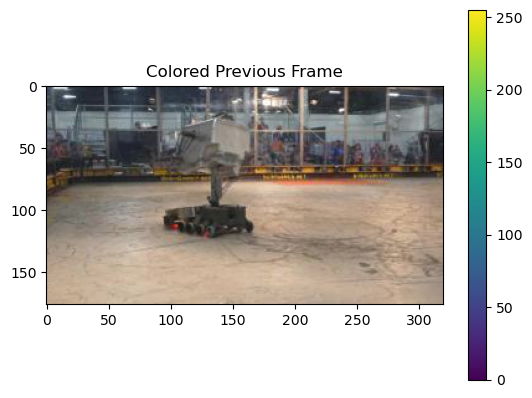

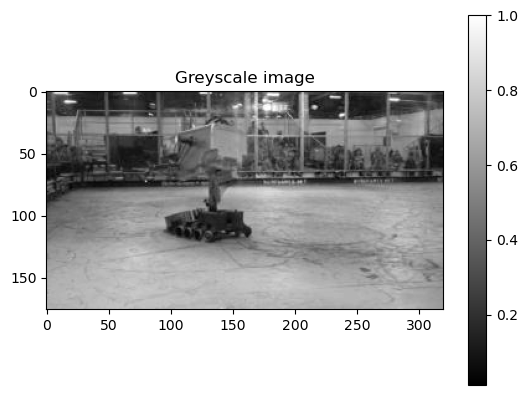

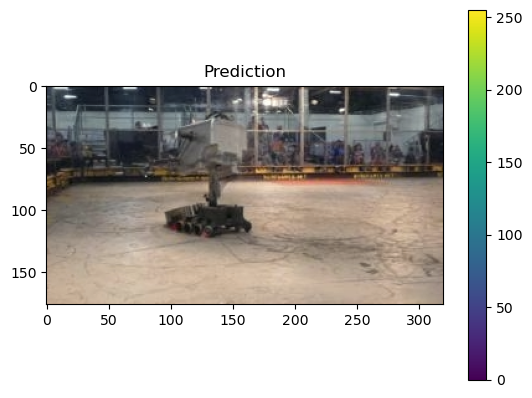

In [13]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

prediction = model(train_features.to(device))
prediction = prediction.cpu()
prediction = prediction.detach()
#prediction = prediction.numpy()
print(prediction.shape)


col_img, flow_img, grey_img, pred_img = data_to_images(train_features[0], prediction[0], use_flow=use_flow, input_only=False)

im = plt.imshow(col_img)
cbar = plt.colorbar(im)
plt.title('Colored Previous Frame')
plt.show()

im = plt.imshow(grey_img, cmap='gray')
cbar = plt.colorbar(im)
plt.title('Greyscale image')
plt.show()

im = plt.imshow(pred_img)
cbar = plt.colorbar(im)
plt.title('Prediction')
plt.show()


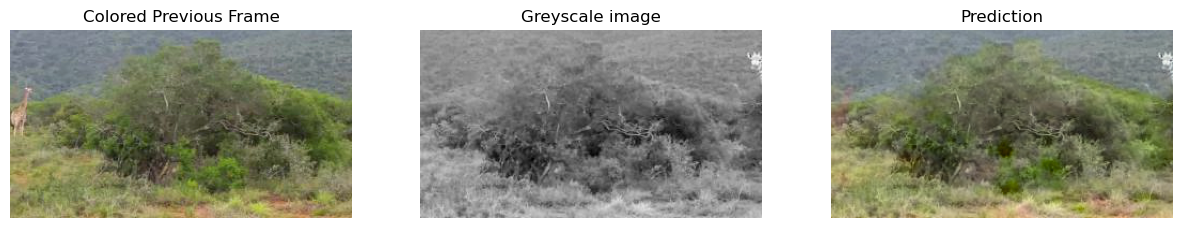

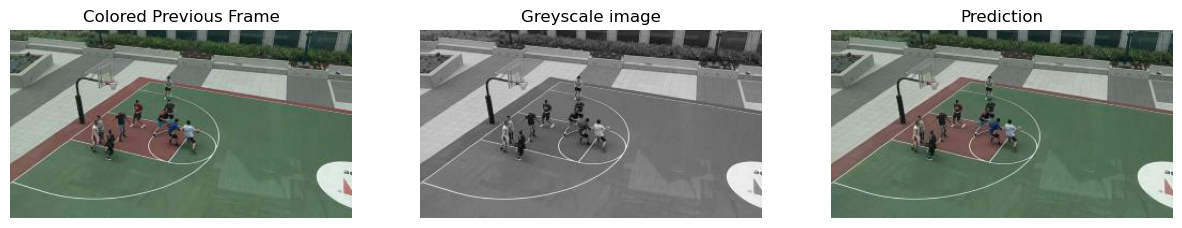

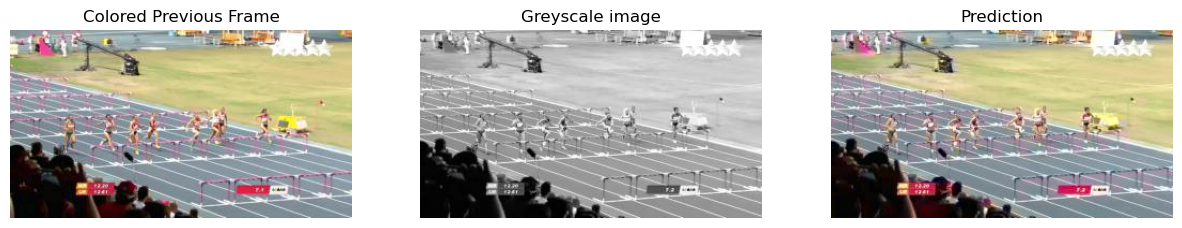

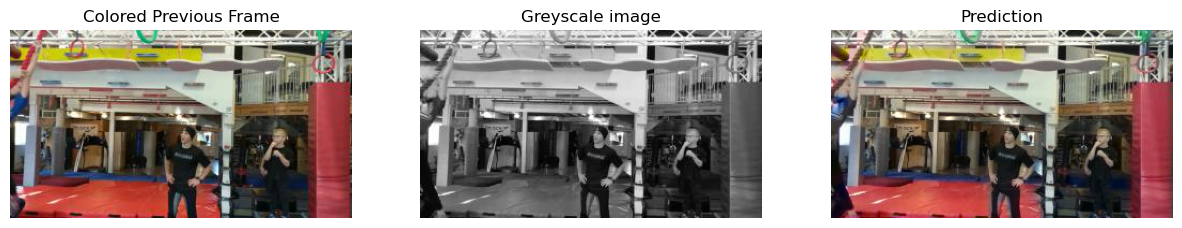

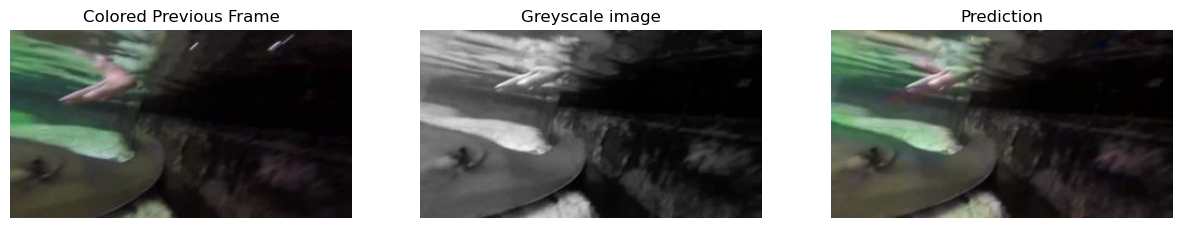

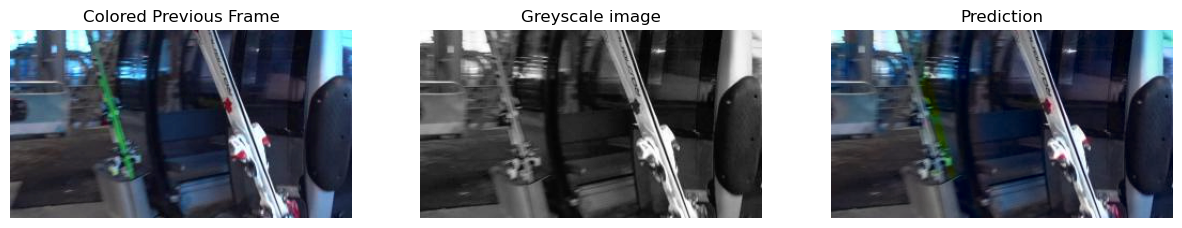

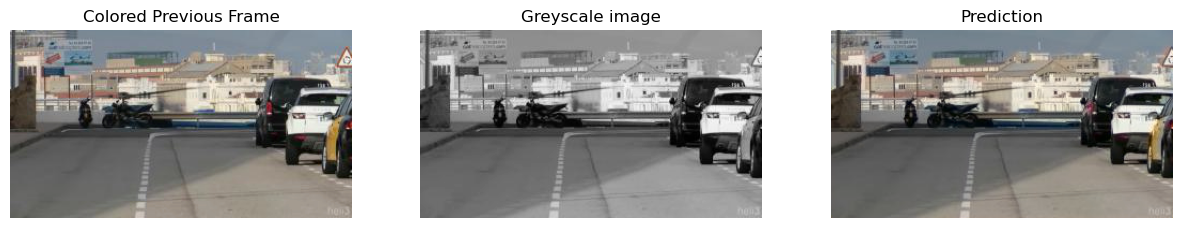

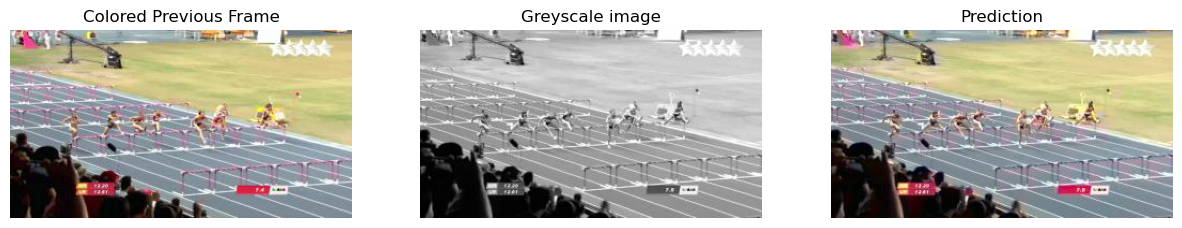

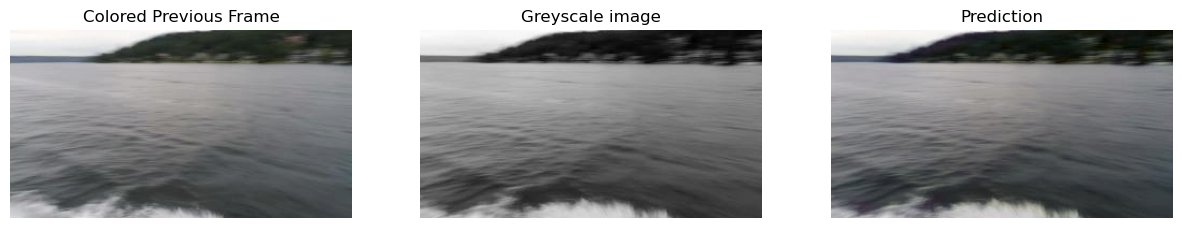

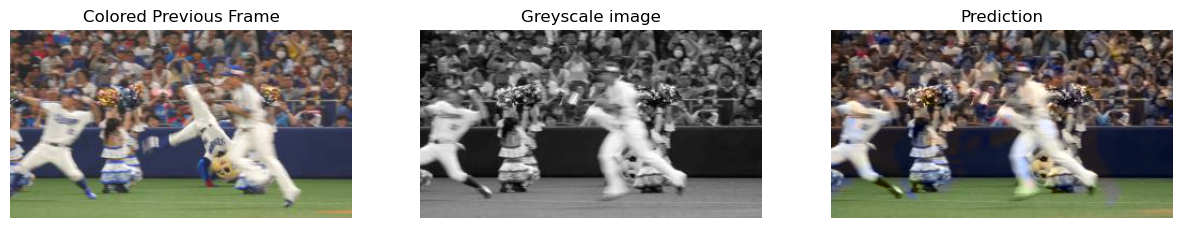

In [15]:
train_features, train_labels = next(iter(train_dataloader))

prediction = model(train_features.to(device))
prediction = prediction.cpu()
prediction = prediction.detach()

for i in range(10):
    col_img, flow_img, grey_img, pred_img = data_to_images(train_features[i], prediction[i], use_flow=use_flow, input_only=False)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(col_img)
    axs[0].axis('off')
    axs[0].set_title('Colored Previous Frame')

    axs[1].imshow(grey_img, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Greyscale image')

    axs[2].imshow(pred_img)
    axs[2].axis('off')
    axs[2].set_title('Prediction')

    plt.show()